In [31]:
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp


In [32]:
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [33]:
torch_geometric.__version__

'2.4.0'

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [35]:
user_df = pd.read_json("./MOOCCube/entities/user.json",lines=True)
user_df = user_df[user_df['course_order'].apply(lambda x: len(x) >= 5)]
# user_df = user_df.sample(1500)
user = []
data_train = []
data_test = []
for index, row in user_df.iterrows():
    user_id = row["id"]
    courses = row["course_order"]

    index_partition = int(len(courses) * 0.75)

    courses_1 = courses[:index_partition]
    courses_2 = courses[index_partition:]
        
    for course in courses_1:
        data_train.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
            
    for course in courses_2:
            data_test.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

In [36]:
train_df.head()

,user_id,course_id,view
0,U_7001215,C_course-v1:TsinghuaX+00740043_2x_2015_T2+sp,1
1,U_7001215,C_course-v1:TsinghuaX+30240184+sp,1
2,U_7001215,C_course-v1:TsinghuaX+00740043X_2015_T2+sp,1
3,U_7423998,C_course-v1:TsinghuaX+30240184_2X+sp,1
4,U_7423998,C_course-v1:SCUT+145033+sp,1


In [37]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  187699
Test Size :  85698


In [38]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['course_id'].values)

In [39]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['course_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['course_id'].isin(train_item_ids))
]


34917 692


In [40]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['course_id'].values)

In [41]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  34917
Number of unique Items :  692


In [42]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 4492,  7160,  7859,  9519, 10725, 12107, 14421, 18646, 20504, 24711,
         27449, 29597, 32444, 32483, 32626, 33393], device='cuda:0'),
 tensor([35213, 35372, 35347, 35425, 35332, 35171, 35289, 35330, 35387, 35310,
         35379, 35296, 35481, 35170, 35391, 35293], device='cuda:0'),
 tensor([35574, 35452, 35596, 35241, 35092, 35342, 35120, 35219, 35082, 35405,
         35285, 35448, 35287, 35551, 34964, 35430], device='cuda:0'))

In [43]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[19930, 19930, 19930,  ..., 35310, 35359, 35309],
        [35292, 35376, 35289,  ..., 16020, 16020, 16020]], device='cuda:0')

In [44]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([35309, 16020], device='cuda:0'),
 tensor([19930, 35292], device='cuda:0'))

In [45]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):  
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [46]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [47]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [48]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim, 
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1) 


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF' 
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )
    
    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users], 
        out[pos_items], 
        out[neg_items], 
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [49]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) + 
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))
  
  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
      
  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
      
  return bpr_loss, reg_loss

In [50]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)
  
  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item 
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [51]:
latent_dim = 64
n_layers = 3 

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005 
K = 20

In [52]:
def recommend(user_embeddings,item_embeddings,user):
    user_emdedding = user_embeddings[user]
    scores = torch.matmul(user_emdedding, item_embeddings.T)
    sorted_indices = torch.argsort(scores, descending=True)
    top_N = 30
    recommended_item_indices = sorted_indices[:30]
    recommended_item_ids = le_item.inverse_transform(recommended_item_indices.cpu().numpy())
    return recommended_item_ids  

In [53]:
groupedTrain = train_df.groupby('user_id')['course_id'].apply(list).reset_index()
groupedTest = test_df.groupby('user_id')['course_id'].apply(list).reset_index()
def getUserCourses(user,df_user):
    return df_user.loc[df_user['id'] == user, 'course_order'].values[0]
def  getUserCoursesTest(user):
    return groupedTest.loc[groupedTest['user_id'] == user, 'course_id'].values[0]
def  getUserCoursesTrain(user):
    return groupedTrain.loc[groupedTrain['user_id'] == user, 'course_id'].values[0]

In [54]:
users_df = test_df[["user_id", "user_id_idx"]]

users_df = users_df.drop_duplicates()
users_df.head()

,user_id,user_id_idx
0,U_7001215,19930
2,U_7423998,22589
4,U_545306,14759
7,U_7594103,23312
9,U_3234246,10534


In [55]:
def evaluate(df_user,us_em,it_em):
    # df_user = df_user.sample(500)
    results = []
    i = 0
    for index, row in df_user.iterrows():
        courses_train = getUserCoursesTrain(row["id"])
        courses_test = getUserCoursesTest(row["id"])
        resultado = users_df[users_df['user_id'] == row["id"]]['user_id_idx'].iloc[0]
        # print(resultado)
        recommended = list(recommend(us_em,it_em,int(resultado)))
        for j in courses_train:
            if j in recommended:
                recommended.remove(j)
        # print(len(recommended))
        recommended = recommended[:15]
        matches = list(set(courses_test).intersection(set(recommended)))
        results.append(
            {
                "recomendations":len(recommended),
                "matches":len(matches),
                "posible":len(courses_test)
            }
        )
        
    return results  

In [56]:
def get_precision(user_df,us_em,it_em):
    results = evaluate(user_df,us_em,it_em)
    df_evaluations = pd.DataFrame(results)
    cont = 0
    pre = 0
    for index, row in df_evaluations.iterrows():
        if row["posible"] < 15:
            precision = row["matches"]/row["posible"]
        else:
            precision = row["matches"]/15
        pre = pre + precision
        cont += 1
    return pre/cont

In [57]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  my_precision = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(train_df.shape[0]/BATCH_SIZE)
    
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []
    
      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )
          users_embedings = final_user_Embed

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      mp = get_precision(user_df,final_user_Embed,final_item_Embed)
      my_precision.append(mp)

  return (
    loss_list_epoch, 
    bpr_loss_list_epoch, 
    reg_loss_list_epoch, 
    recall_list, 
    precision_list,final_user_Embed,final_item_Embed,my_precision
  )

In [58]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([35609, 64])]


In [59]:
light_loss, light_bpr, light_reg, light_recall, light_precision,us_em,it_em,my_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
epoch_list = [(i+1) for i in range(EPOCHS)]

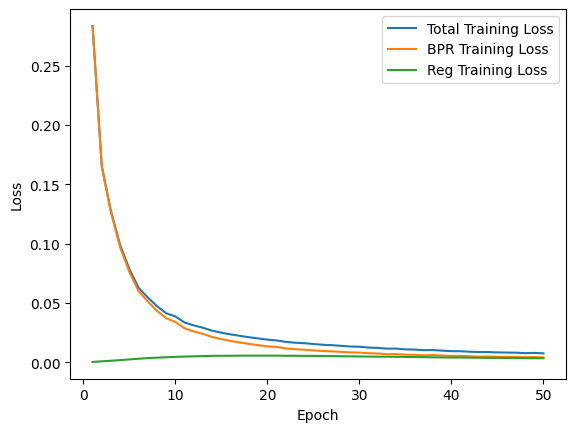

In [61]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

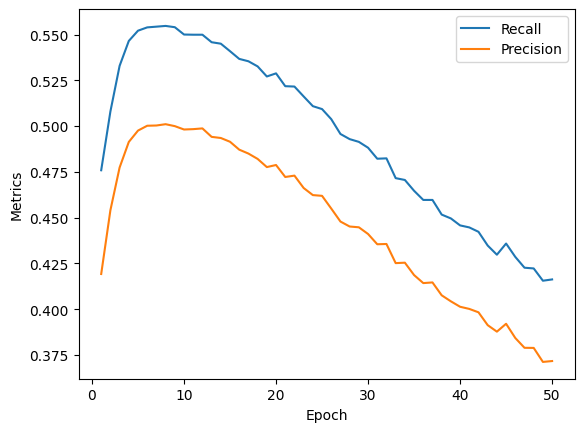

In [63]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, my_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [64]:
print(my_precision)

[0.4192697770260326, 0.4540794356779449, 0.47739177375529734, 0.49135935154064153, 0.49755846852247076, 0.5002032210898968, 0.5003378480245062, 0.5010495065740367, 0.4999899303726964, 0.49815186126510164, 0.49834953989950204, 0.49875023863339096, 0.49413667782513976, 0.49351456554824585, 0.4914594132911865, 0.4871516053039388, 0.48501035071187276, 0.4820925043173525, 0.47764133159785893, 0.4787671557153491, 0.47223229129321, 0.4729741781163746, 0.46621636311902054, 0.46234516192631553, 0.461936725180993, 0.45499283264555485, 0.4479011234681859, 0.4451914068118246, 0.44476392668248055, 0.44110655281718364, 0.43550866537592503, 0.4356499407298481, 0.4252051954689679, 0.42544343172619176, 0.4186806331363462, 0.41430485462833994, 0.41466141447025084, 0.4076384382897007, 0.40434350830218496, 0.40138249172745666, 0.400208674216325, 0.39834921794927286, 0.39134612114249934, 0.3877949178168303, 0.39209293616459495, 0.38432657928319364, 0.3789745093873484, 0.37891366079355066, 0.371267857067756